## ASIDE SECTION 1 - processing to verify all the train2017 files are uploaded
### should be 118287 images

### have already uploaded the files from laptop to gdrive using my own script

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
!ls './gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/'

COCO_train2017_118k  Rishabh_DO_NOT_TOUCH_PLS_1  train2017.zip


In [ ]:
!ls './gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/Rishabh_DO_NOT_TOUCH_PLS_1' | wc -l

ls: cannot open directory './gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/Rishabh_DO_NOT_TOUCH_PLS_1': Input/output error
0


In [ ]:
import os
import pickle
import sys

In [ ]:
IMGSDIR_COCO_TRAIN2017 = r'./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/Rishabh_DO_NOT_TOUCH_PLS_1'
WORKDIR_COCO_TRAIN2017 = '/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoTrain2017_1/'

In [ ]:
gdrive_coco_train2017_118287_listdir = os.listdir(IMGSDIR_COCO_TRAIN2017)

In [ ]:
len(gdrive_coco_train2017_118287_listdir)

118287

In [ ]:
## pickle the data
with open(WORKDIR_COCO_TRAIN2017+'gdrive_coco_train2017_118287_listdir.pkl', 'wb') as handle:
  pickle.dump(gdrive_coco_train2017_118287_listdir, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done")

Pickling done


In [ ]:
print(f"Size of pickled data = {sys.getsizeof(gdrive_coco_train2017_118287_listdir)} bytes")

Size of pickled data = 1043560 bytes


In [ ]:
del gdrive_coco_train2017_118287_listdir

In [ ]:
## reload from picked file - output of listdir on google drive location
if True:
  with open(WORKDIR_COCO_TRAIN2017+'gdrive_coco_train2017_118287_listdir.pkl', 'rb') as handle:
    gdrive_coco_train2017_118287_listdir = pickle.load(handle)

len(gdrive_coco_train2017_118287_listdir)

118287

In [ ]:
## reload from picked file - output of listdir on laptop folder
if True:
  with open(WORKDIR_COCO_TRAIN2017+'laptop_coco_train2017_listdir.pkl', 'rb') as handle:
    laptop_coco_train2017_listdir = pickle.load(handle)

len(laptop_coco_train2017_listdir)

118287

In [ ]:
upload_pending = list( set(gdrive_coco_train2017_118287_listdir) - set(laptop_coco_train2017_listdir) )

In [ ]:
len(upload_pending)  ## if 0, then the images in the folders on the gdrive and laptop match

0

In [ ]:
## double check that all values in the listdir of gdrive are unique

In [ ]:
import pandas as pd

In [ ]:
dfup = pd.DataFrame(gdrive_coco_train2017_118287_listdir, columns=['fname'])
dfup.head()

,fname
0,000000407952.jpg
1,000000031471.jpg
2,000000208524.jpg
3,000000480872.jpg
4,000000257301.jpg


In [ ]:
dfup['fname'].nunique()  ## should be 118287

118287

In [ ]:
len(dfup)   ## also should be 118287

118287

## ASIDE SECTION 2 - BREAK COCO TRAIN2017 118k FILES INTO SMALLER PARTS IN FOLDERS
### total images in COCO_TRAIN2017 = 118287 jpgs

### using the start and end indexes, using the os.listdir output on the folder
###     create a new folder and copy that set of images os.listdir(xxx)[sidx:eidx]

In [ ]:
import pickle
import os
import sys
import shutil
import datetime
import time

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
COCO_TRAIN2017_IMGSDIR = r'./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/Rishabh_DO_NOT_TOUCH_PLS_1/'
WORKDIR_COCO_TRAIN2017 = r'./gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoTrain2017_1/'
TARGETDIR = r'./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/' ## the dedicated folder for subset of images will be made here

In [ ]:
## reload from picked file - output of listdir on google drive location = r'./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/Rishabh_DO_NOT_TOUCH_PLS_1/'
if True:
  with open(WORKDIR_COCO_TRAIN2017+'gdrive_coco_train2017_118287_listdir.pkl', 'rb') as handle:
    gdrive_coco_train2017_118287_listdir = pickle.load(handle)

len(gdrive_coco_train2017_118287_listdir)

118287

In [ ]:
gdrive_coco_train2017_118287_listdir[:3]

['000000407952.jpg', '000000031471.jpg', '000000208524.jpg']

In [ ]:
## add the full path to the file names
gdrive_coco_train2017_118287_listdir = [COCO_TRAIN2017_IMGSDIR + f for f in gdrive_coco_train2017_118287_listdir]
gdrive_coco_train2017_118287_listdir[:3]

['./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/Rishabh_DO_NOT_TOUCH_PLS_1/000000407952.jpg',
 './gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/Rishabh_DO_NOT_TOUCH_PLS_1/000000031471.jpg',
 './gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/Rishabh_DO_NOT_TOUCH_PLS_1/000000208524.jpg']

In [ ]:
## slicing will be done on the gdrive_coco_train2017_118287_listdir array
## i.e. gdrive_coco_train2017_118287_listdir[ sidx : eidx ]

In [ ]:
def copy_the_files(_sidx, _eidx, _files_arr, _copyTo_path, _print_freq = 50):
    start_tick = time.time()
    cnt_processed , cnt_copied , cnt_problem = 0, 0, 0
    problem_files = []
    for file_to_be_copied in _files_arr[_sidx : _eidx]:
      if cnt_processed % _print_freq == 0:
        print(f"At {datetime.datetime.now().strftime('%H:%M:%S')} :: Processed = {cnt_processed} , Copied = {cnt_copied} , Problem = {cnt_problem}")
      cnt_processed += 1
      try:
        shutil.copy(file_to_be_copied, _copyTo_path)
        cnt_copied += 1
      except Exception as e:
        cnt_problem += 1
        problem_files.append(file_to_be_copied)
        #print(f"Error: {e}")
    
    print(f"\n\nExpected count of copied files = {_eidx - _sidx}\nTime taken = { time.time() - start_tick } seconds")
    print(f"\nProcessed = {cnt_processed} , Copied = {cnt_copied} , Problem = {cnt_problem}\n")
    
    return problem_files

### copying   for indexes     start = 0 , end = 5000

In [ ]:
sidx, eidx = 0, 5000

In [ ]:
copyTo_path = TARGETDIR + 'coco_test2017_subset_' + str(sidx) + '_' + str(eidx) + '/'
copyTo_path

'./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_0_5000/'

In [ ]:
if not os.path.isdir(copyTo_path):
    os.mkdir(copyTo_path)
    print(f"\n\nCreated folder on Google Drive for copyTo_path : {copyTo_path}\n\n")
    
    problem_files_arr = copy_the_files(sidx, eidx, gdrive_coco_train2017_118287_listdir, copyTo_path)
else:
    print(f"\n\nFATAL ERROR: copyTo_path already exists : {copyTo_path}\n\n")

if len(problem_files_arr) > 0:
  print(f"\n\nThere were problems.\n")
else:
  print(f"\n\nSuccess, no problems\n")



Created folder on Google Drive for copyTo_path : ./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_0_5000/


At 16:12:55 :: Processed = 0 , Copied = 0 , Problem = 0
At 16:12:55 :: Processed = 50 , Copied = 50 , Problem = 0
At 16:12:56 :: Processed = 100 , Copied = 100 , Problem = 0
At 16:12:56 :: Processed = 150 , Copied = 150 , Problem = 0
At 16:12:57 :: Processed = 200 , Copied = 200 , Problem = 0
At 16:12:57 :: Processed = 250 , Copied = 250 , Problem = 0
At 16:12:58 :: Processed = 300 , Copied = 300 , Problem = 0
At 16:12:58 :: Processed = 350 , Copied = 350 , Problem = 0
At 16:12:59 :: Processed = 400 , Copied = 400 , Problem = 0
At 16:12:59 :: Processed = 450 , Copied = 450 , Problem = 0
At 16:13:00 :: Processed = 500 , Copied = 500 , Problem = 0
At 16:13:00 :: Processed = 550 , Copied = 550 , Problem = 0
At 16:13:01 :: Processed = 600 , Copied = 600 , Problem = 0
At 16:13:02 :: Processed = 650 , Copied = 650 , Problem = 0
At 16:13:02 :: Processed

In [ ]:
len(os.listdir('./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_0_5000/'))

5000

### copying   for indexes     start = 5000 , end = 10000

In [ ]:
sidx, eidx = 5000, 10000

In [ ]:
copyTo_path = TARGETDIR + 'coco_test2017_subset_' + str(sidx) + '_' + str(eidx) + '/'
copyTo_path

'./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_5000_10000/'

In [ ]:
if not os.path.isdir(copyTo_path):
    os.mkdir(copyTo_path)
    print(f"\n\nCreated folder on Google Drive for copyTo_path : {copyTo_path}\n\n")
    
    problem_files_arr = copy_the_files(sidx, eidx, gdrive_coco_train2017_118287_listdir, copyTo_path)
else:
    print(f"\n\nFATAL ERROR: copyTo_path already exists : {copyTo_path}\n\n")

if len(problem_files_arr) > 0:
  print(f"\n\nThere were problems.\n")
else:
  print(f"\n\nSuccess, no problems\n")



Created folder on Google Drive for copyTo_path : ./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_5000_10000/


At 16:26:34 :: Processed = 0 , Copied = 0 , Problem = 0
At 16:26:48 :: Processed = 50 , Copied = 50 , Problem = 0
At 16:27:01 :: Processed = 100 , Copied = 100 , Problem = 0
At 16:27:15 :: Processed = 150 , Copied = 150 , Problem = 0
At 16:27:29 :: Processed = 200 , Copied = 200 , Problem = 0
At 16:27:45 :: Processed = 250 , Copied = 250 , Problem = 0
At 16:27:59 :: Processed = 300 , Copied = 300 , Problem = 0
At 16:28:14 :: Processed = 350 , Copied = 350 , Problem = 0
At 16:28:30 :: Processed = 400 , Copied = 400 , Problem = 0
At 16:28:45 :: Processed = 450 , Copied = 450 , Problem = 0
At 16:28:59 :: Processed = 500 , Copied = 500 , Problem = 0
At 16:29:12 :: Processed = 550 , Copied = 550 , Problem = 0
At 16:29:27 :: Processed = 600 , Copied = 600 , Problem = 0
At 16:29:41 :: Processed = 650 , Copied = 650 , Problem = 0
At 16:29:55 :: Proce

In [ ]:
len(os.listdir('./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_5000_10000/'))

5000

### copying   for indexes     start = 10000 , end = 15000

In [ ]:
sidx, eidx = 10000, 15000

In [ ]:
copyTo_path = TARGETDIR + 'coco_test2017_subset_' + str(sidx) + '_' + str(eidx) + '/'
copyTo_path

'./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_10000_15000/'

In [ ]:
if not os.path.isdir(copyTo_path):
    os.mkdir(copyTo_path)
    print(f"\n\nCreated folder on Google Drive for copyTo_path : {copyTo_path}\n\n")
    
    problem_files_arr = copy_the_files(sidx, eidx, gdrive_coco_train2017_118287_listdir, copyTo_path)
else:
    print(f"\n\nFATAL ERROR: copyTo_path already exists : {copyTo_path}\n\n")

if len(problem_files_arr) > 0:
  print(f"\n\nThere were problems.\n")
else:
  print(f"\n\nSuccess, no problems\n")



Created folder on Google Drive for copyTo_path : ./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_10000_15000/


At 16:51:33 :: Processed = 0 , Copied = 0 , Problem = 0
At 16:51:47 :: Processed = 50 , Copied = 50 , Problem = 0
At 16:52:01 :: Processed = 100 , Copied = 100 , Problem = 0
At 16:52:14 :: Processed = 150 , Copied = 150 , Problem = 0
At 16:52:28 :: Processed = 200 , Copied = 200 , Problem = 0
At 16:52:42 :: Processed = 250 , Copied = 250 , Problem = 0
At 16:52:55 :: Processed = 300 , Copied = 300 , Problem = 0
At 16:53:08 :: Processed = 350 , Copied = 350 , Problem = 0
At 16:53:21 :: Processed = 400 , Copied = 400 , Problem = 0
At 16:53:34 :: Processed = 450 , Copied = 450 , Problem = 0
At 16:53:49 :: Processed = 500 , Copied = 500 , Problem = 0
At 16:54:03 :: Processed = 550 , Copied = 550 , Problem = 0
At 16:54:17 :: Processed = 600 , Copied = 600 , Problem = 0
At 16:54:35 :: Processed = 650 , Copied = 650 , Problem = 0
At 16:54:48 :: Proc

In [ ]:
len(os.listdir('./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_10000_15000/'))

5000

### copying   for indexes     start = 15000 , end = 20000

In [ ]:
sidx, eidx = 15000, 20000

In [ ]:
copyTo_path = TARGETDIR + 'coco_test2017_subset_' + str(sidx) + '_' + str(eidx) + '/'
copyTo_path

'./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_15000_20000/'

In [ ]:
if not os.path.isdir(copyTo_path):
    os.mkdir(copyTo_path)
    print(f"\n\nCreated folder on Google Drive for copyTo_path : {copyTo_path}\n\n")
    
    problem_files_arr = copy_the_files(sidx, eidx, gdrive_coco_train2017_118287_listdir, copyTo_path)
else:
    print(f"\n\nFATAL ERROR: copyTo_path already exists : {copyTo_path}\n\n")

if len(problem_files_arr) > 0:
  print(f"\n\nThere were problems.\n")
else:
  print(f"\n\nSuccess, no problems\n")



Created folder on Google Drive for copyTo_path : ./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_15000_20000/


At 17:18:41 :: Processed = 0 , Copied = 0 , Problem = 0
At 17:18:56 :: Processed = 50 , Copied = 50 , Problem = 0
At 17:19:10 :: Processed = 100 , Copied = 100 , Problem = 0
At 17:19:24 :: Processed = 150 , Copied = 150 , Problem = 0
At 17:19:40 :: Processed = 200 , Copied = 200 , Problem = 0
At 17:19:54 :: Processed = 250 , Copied = 250 , Problem = 0
At 17:20:08 :: Processed = 300 , Copied = 300 , Problem = 0
At 17:20:22 :: Processed = 350 , Copied = 350 , Problem = 0
At 17:20:36 :: Processed = 400 , Copied = 400 , Problem = 0
At 17:20:49 :: Processed = 450 , Copied = 450 , Problem = 0
At 17:21:02 :: Processed = 500 , Copied = 500 , Problem = 0
At 17:21:17 :: Processed = 550 , Copied = 550 , Problem = 0
At 17:21:29 :: Processed = 600 , Copied = 600 , Problem = 0
At 17:21:42 :: Processed = 650 , Copied = 650 , Problem = 0
At 17:21:55 :: Proc

In [ ]:
len(os.listdir('./gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_15000_20000/'))

5000

## Data Exploration on the annotations dataset - which contains the captions

In [ ]:
################################################
## data exploration on the annotations dataset
################################################

## about val2017 ::::
## max caption length = 247 for val2017    'A large square concrete wall, which shows peo...'
## 25014 caption entries for the 5000 images

## about train2017 ::::
## ???? caption entries for the ???? images
## max caption length = 250 for train2017  - multiple entries
##      'Front view of person holding animal spotted pr...'
##      'The image shows an entertainment cubby in the ...'
##      'The vee shaped part of a white-walled room sho...'
##      'The scene shows outdoors, furthest to closest,...'
##      'Black and white of two women sitting on a marb...'
##      'From furthest to nearest, the view shows, clou...'
##      'From below view of the head, neck, and paws of...'
##      'A room with long table with widescreen televis...'
##      'Two men holding tennis rackets up in a hand on...'
##      'Restaurant table top with logo in middle and a...'
##      'A near-ground shot shows logo-covered wall and...'
##      'An apartment with an open floor plan,  that al...'
##      'A black and white shot shows a  bus interior w...'
##      'An image from a copyrighted foodie site shows ...'

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import json
import pandas as pd

In [ ]:
OPDIR = '/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/'
IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_val2017_wget_1/val2017/'
IPDIRANNO = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_annotations_trainval2017/'

In [ ]:
os.listdir('/content/gdrive/My Drive/ThesisStoryGen/Data/coco_annotations_trainval2017/')

['captions_val2017.json', 'captions_train2017.json', 'sample_data_in_file.txt']

In [ ]:
with open(IPDIRANNO+'captions_val2017.json', 'r') as f:
  data = json.load(f)
  print(f"data.keys() = {data.keys()}") # dict_keys(['info', 'licenses', 'images', 'annotations'])
  print(f"type(data['annotations']) = {type(data['annotations'])}") # is a list
  print(f"type(data['images']) = {type(data['images'])}")      # also is a list

data.keys() = dict_keys(['info', 'licenses', 'images', 'annotations'])
type(data['annotations']) = <class 'list'>
type(data['images']) = <class 'list'>


In [ ]:
dfanno = pd.DataFrame(data=data['annotations'])
# dfanno.columns = Index(['image_id', 'id', 'caption'], dtype='object') 
# dfanno.dtypes =
#   image_id     int64
#   id           int64
#   caption     object
#   dtype: object

dfimages = pd.DataFrame(data=data['images'])
# dfimages.columns = Index(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'], dtype='object')
# dfimages.dtypes =
#   license           int64
#   file_name        object
#   coco_url         object
#   height            int64
#   width             int64
#   date_captured    object
#   flickr_url       object
#   id                int64
#   dtype: object
## of above, am dropping useless columns
dfimages.drop(['license', 'coco_url', 'date_captured', 'flickr_url'], axis = 1, inplace=True)

## columns remaining in the dfs are:
# dfanno columns are      image_id , id , caption
#                         179765   , 38 ,	A black Honda motorcycle parked in front of a ...
# dfimages columns are    file_name        , height ,  width , id
#                         000000397133.jpg , 427    ,  640   , 397133

## the captions are not ordered for each image and seem to randomly placed

In [ ]:
dfanno['caplen'] = dfanno.caption.str.len()
print(f"Longest length of captions = {dfanno.caplen.max()}")   # = 250, without any pre-processing
caption_values_with_longest_caption_len = dfanno.caption[dfanno.caplen == dfanno.caplen.max()].to_string(index=False)
print(f"{type(caption_values_with_longest_caption_len)}")
print(f"{caption_values_with_longest_caption_len}")
print(f"Count of captions with the maximum length = {dfanno.caption[dfanno.caplen == dfanno.caplen.max()].count()}")

Longest length of captions = 247
<class 'str'>
 A large square concrete wall, which shows peop...
Count of captions with the maximum length = 1


In [ ]:
dfanno.head(2)

,image_id,id,caption,caplen
0,179765,38,A black Honda motorcycle parked in front of a ...,53
1,179765,182,A Honda motorcycle parked in a grass driveway,45


In [ ]:
## marrying the "annotations" and the "images" keys info together into dfanno
dfanno = dfanno.merge(dfimages, left_on='image_id', right_on='id', how='inner')
dfanno.drop(['id_y'], axis=1, inplace=True)
dfanno.rename(columns={'id_x':'id'}, inplace=True)
dfanno.columns

Index(['image_id', 'id', 'caption', 'caplen', 'file_name', 'height', 'width'], dtype='object')

In [ ]:
dfanno.head(15)

,image_id,id,caption,caplen,file_name,height,width
0,179765,38,A black Honda motorcycle parked in front of a ...,53,000000179765.jpg,480,640
1,179765,182,A Honda motorcycle parked in a grass driveway,45,000000179765.jpg,480,640
2,179765,479,A black Honda motorcycle with a dark burgundy ...,51,000000179765.jpg,480,640
3,179765,6638,Ma motorcycle parked on the gravel in front of...,55,000000179765.jpg,480,640
4,179765,6803,A motorcycle with its brake extended standing ...,53,000000179765.jpg,480,640
5,190236,401,An office cubicle with four different types of...,57,000000190236.jpg,393,640
6,190236,644,The home office space seems to be very cluttered.,49,000000190236.jpg,393,640
7,190236,2846,an office with desk computer and chair and lap...,50,000000190236.jpg,393,640
8,190236,3464,Office setting with a lot of computer screens.,46,000000190236.jpg,393,640
9,190236,4700,A desk and chair in an office cubicle.,38,000000190236.jpg,393,640


In [ ]:
## number of total captions
## ideally should be 5000 images * 5 captions per image = 25000 , some images have more than 5 captions
len(dfanno)

25014

In [ ]:
## number of images as per the annotations file - as expected
dfanno['file_name'].nunique()

5000

# Training model on the Coco Val2017 dataset

## Train data = 4800 images
## Test  data = 200  images

## Note: each image will have multiple captions (up to 5 as some may be discarded)

## Using this LINK: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8
## Image captioning with Keras

In [1]:
import os
import sys
import json
import time
import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import pickle
#import itertools
from sklearn.model_selection import train_test_split
import PIL
import PIL.Image

In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
OPDIR = '/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/'
IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_val2017_wget_1/val2017/'
IPDIRANNO = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_annotations_trainval2017/'
WORD_EMBEDDINGS_DIR = '/content/gdrive/My Drive/ThesisStoryGen/Data/WordEmbeddings/'

## ONLY ONCE - create "descriptions" dictionary

In [ ]:
## Now, we create a dictionary named “descriptions” which contains the name of the image
## (without the .jpg extension) as keys and a list captions for the corresponding
## image as values.

### Load the info from the Val2017 annotations file (i.e. captions_val2017.json) and process it

In [ ]:
os.listdir('/content/gdrive/My Drive/ThesisStoryGen/Data/coco_annotations_trainval2017/')

['captions_val2017.json', 'captions_train2017.json', 'sample_data_in_file.txt']

In [ ]:
## from the annotations file, load the captions

with open(IPDIRANNO+'captions_val2017.json', 'r') as f:
  data = json.load(f)
  #data.keys() # dict_keys(['info', 'licenses', 'images', 'annotations'])
  #type(data['annotations']) # is a list
  #type(data['images'])      # also is a list

dfanno = pd.DataFrame(data=data['annotations'])
# dfanno.columns = Index(['image_id', 'id', 'caption'], dtype='object') 
# dfanno.dtypes =
#   image_id     int64
#   id           int64
#   caption     object
#   dtype: object

dfimages = pd.DataFrame(data=data['images'])
# dfimages.columns = Index(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'], dtype='object')
# dfimages.dtypes =
#   license           int64
#   file_name        object
#   coco_url         object
#   height            int64
#   width             int64
#   date_captured    object
#   flickr_url       object
#   id                int64
#   dtype: object
## of above, am dropping useless columns
dfimages.drop(['license', 'coco_url', 'date_captured', 'flickr_url'], axis = 1, inplace=True)

## columns remaining in the dfs are:
# dfanno columns are      image_id , id , caption
#                         179765   , 38 ,	A black Honda motorcycle parked in front of a ...
# dfimages columns are    file_name        , height ,  width , id
#                         000000397133.jpg , 427    ,  640   , 397133

## the captions are not ordered for each image and seem to be randomly placed

dfanno.head(3)

,image_id,id,caption
0,179765,38,A black Honda motorcycle parked in front of a ...
1,179765,182,A Honda motorcycle parked in a grass driveway
2,190236,401,An office cubicle with four different types of...


In [ ]:
## marrying the "annotations" and the "images" keys info together into dfanno
## the file_name column has the actual image name from the "image" key section
dfanno = dfanno.merge(dfimages, how="inner", left_on='image_id', right_on='id')
dfanno.drop(['height', 'width', 'id_y'], axis = 1, inplace=True)
dfanno.rename(columns={'id_x':'id'}, inplace=True)
dfanno.head(3)

,image_id,id,caption,file_name
0,179765,38,A black Honda motorcycle parked in front of a ...,000000179765.jpg
1,179765,182,A Honda motorcycle parked in a grass driveway,000000179765.jpg
2,179765,479,A black Honda motorcycle with a dark burgundy ...,000000179765.jpg


In [ ]:
## Mapping image with captions using dictionary

def create_descriptions_dictionary(_dfin):
    descriptions = {}
    for row in _dfin.itertuples():
      rowdict = row._asdict()
      img_filename = rowdict['file_name'].split('.')[0] # drop the .jpg part
      img_caption = rowdict['caption']
      if(img_filename not in descriptions):
        descriptions[img_filename] = [img_caption]
      else:
        descriptions[img_filename].append(img_caption)
    return descriptions

descriptions = create_descriptions_dictionary(dfanno)

In [ ]:
dict(list(descriptions.items())[12:19])

{'000000012667': ['The telephone has a banana where the receiver should be.',
  'A banana replacing the phone on an answering machine',
  'A phone with a banana where the receiver should be.',
  'A telephone has it receiver replaced with a banana.',
  'A banana placed on a phone on a table.'],
 '000000065485': ['A dog driving an SUV in an open grass covered field.',
  'A dog sits in the front seat of a jeep. ',
  'A dog is sitting inside a red car.',
  'A red truck has a black dog in the drivers chair.',
  'A dog sitting in the front seat of a truck.'],
 '000000289393': ['Set of toy animals sitting in front of a red wooden wagon.',
  'Several toy animals - a bull, giraffe, deer and parakeet.',
  'Some toy animals on the ground near a picture',
  "Children's toy animals are strewn across a floor.",
  'A display of vintage animal toys on the floor.'],
 '000000338325': ['A striped plane flying up into the sky as the sun shines behind it.',
  'An airplane is ascending into the white sky',


In [ ]:
## example of caption with a hyphen - in the text
descriptions['000000289393']

['Set of toy animals sitting in front of a red wooden wagon.',
 'Several toy animals - a bull, giraffe, deer and parakeet.',
 'Some toy animals on the ground near a picture',
 "Children's toy animals are strewn across a floor.",
 'A display of vintage animal toys on the floor.']

### Data cleaning on the "descriptions" dictionary values

### Following clean up done:
### 1. lower casing
### 2. punctuation removal
### 3. remove any words with length = 1
### 4. remove any words with alphanumeric

In [ ]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        # tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # store as string
        desc_list[i] =  ' '.join(desc)

In [ ]:
## example of caption which had the hyphen - in the text
descriptions['000000289393']

['set of toy animals sitting in front of red wooden wagon',
 'several toy animals bull giraffe deer and parakeet',
 'some toy animals on the ground near picture',
 'childrens toy animals are strewn across floor',
 'display of vintage animal toys on the floor']

### Pickle the "descriptions" dictionary

In [ ]:
OPDIR

'/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/'

In [ ]:
## pickle the descriptions dictionary
with open(OPDIR+'val2017_all_5k_images_descriptions_pickled_1.pkl', 'wb') as handle:
    pickle.dump(descriptions, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling of 'descriptions' done")

Pickling of 'descriptions' done


In [ ]:
print(f"Size of 'descriptions' dictionary = {sys.getsizeof(descriptions)} bytes")

Size of 'descriptions' dictionary = 147560 bytes


In [ ]:
del descriptions

In [ ]:
print(f"Size of 'descriptions' dictionary = {sys.getsizeof(descriptions)} bytes")

NameError: ignored

## ALWAYS - Reload "descriptions" dictionary from picked file

### Reload the dictionary named “descriptions” which contains the name of the image (without the .jpg extension) as keys and a list captions for the corresponding image as values.
###
### sys.getsizeof(descriptions) should be = 147560 bytes
### 
### Example of an entry: descriptions['000000289393'] should output as below:
### ['set of toy animals sitting in front of red wooden wagon',
###  'several toy animals bull giraffe deer and parakeet',
###  'some toy animals on the ground near picture',
###  'childrens toy animals are strewn across floor',
###  'display of vintage animal toys on the floor']

In [4]:
## Reload the dictionary named “descriptions” which contains the name of the image
## (without the .jpg extension) as keys and a list captions for the corresponding
## image as values.

In [5]:
OPDIR

'/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/'

In [6]:
## reload from picked file
if True:
  with open(OPDIR+'val2017_all_5k_images_descriptions_pickled_1.pkl', 'rb') as handle:
    descriptions = pickle.load(handle)

print(f"Size of 'descriptions' dictionary = {sys.getsizeof(descriptions)} bytes\n")

print(f"descriptions['000000289393']")
descriptions['000000289393']

Size of 'descriptions' dictionary = 147560 bytes

descriptions['000000289393']


['set of toy animals sitting in front of red wooden wagon',
 'several toy animals bull giraffe deer and parakeet',
 'some toy animals on the ground near picture',
 'childrens toy animals are strewn across floor',
 'display of vintage animal toys on the floor']

In [7]:
len(descriptions)

5000

## ALWAYS - Using the descriptions dictionary, split data into a train and val.
### Will make two lists containing only the file name without the .jpg

In [8]:
all_imgs_for_splitting = [key for key in descriptions.keys()]

TRAIN_SIZE_N = 4800 ## mean balance 5000 - TRAIN_SIZE_N will be set to val data size.
train_imgs_arr, val_imgs_arr = train_test_split(all_imgs_for_splitting, train_size = TRAIN_SIZE_N, random_state=444)

print(f"Sizes of: Train = {len(train_imgs_arr)},  Val = {len(val_imgs_arr)},  Train = {len(all_imgs_for_splitting)}")
del all_imgs_for_splitting

Sizes of: Train = 4800,  Val = 200,  Train = 5000


## ALWAYS - Add the    startseq    and    endseq    tokens to all the descriptions and create 3 sets: one for all the descriptions, one for the train, one for the test

### At end of this section we will have four dictionaries of captions:
###    variable --------------------------------------------------- start/end seq present ---- which images
### 1) descriptions ------------------------------------------------------ NO ------------------------- all 5k
### 2) descriptions_all_start_end_seq ------------------------ YES -------------------------- all 5k
### 3) descriptions_train_start_end_seq -------------------- YES ----------------------- train number (4800)
### 4) descriptions_val_start_end_seq ----------------------- YES ----------------------- val number (200)

In [9]:
## see the unchanged descriptions - note no startseq and endseq present now
i=0
for k, v in descriptions.items():
  i+=1
  if i>5:
    break
  print(k, v)

000000179765 ['black honda motorcycle parked in front of garage', 'honda motorcycle parked in grass driveway', 'black honda motorcycle with dark burgundy seat', 'ma motorcycle parked on the gravel in front of garage', 'motorcycle with its brake extended standing outside']
000000190236 ['an office cubicle with four different types of computers', 'the home office space seems to be very cluttered', 'an office with desk computer and chair and laptop', 'office setting with lot of computer screens', 'desk and chair in an office cubicle']
000000331352 ['small closed toilet in cramped space', 'tan toilet and sink combination in small room', 'this is an advanced toilet with sink and control panel', 'closeup picture of toilet with fountain', 'off white toilet with faucet and controls']
000000517069 ['two women waiting at bench next to street', 'woman sitting on bench and woman standing waiting for the bus', 'woman sitting on bench in the middle of the city', 'woman sitting on bench and woman sta

In [10]:
## update the captions of all descriptions

descriptions_all_start_end_seq = descriptions.copy()

for k, v in descriptions_all_start_end_seq.items():
  updated_cap_arr = [''.join(['startseq ', caption, ' endseq']) for caption in v]
  descriptions_all_start_end_seq.update( { k : updated_cap_arr } )

In [11]:
## see the unchanged descriptions - note no startseq and endseq present STILL
i=0
for k, v in descriptions.items():
  i+=1
  if i>5:
    break
  print(k, v)

000000179765 ['black honda motorcycle parked in front of garage', 'honda motorcycle parked in grass driveway', 'black honda motorcycle with dark burgundy seat', 'ma motorcycle parked on the gravel in front of garage', 'motorcycle with its brake extended standing outside']
000000190236 ['an office cubicle with four different types of computers', 'the home office space seems to be very cluttered', 'an office with desk computer and chair and laptop', 'office setting with lot of computer screens', 'desk and chair in an office cubicle']
000000331352 ['small closed toilet in cramped space', 'tan toilet and sink combination in small room', 'this is an advanced toilet with sink and control panel', 'closeup picture of toilet with fountain', 'off white toilet with faucet and controls']
000000517069 ['two women waiting at bench next to street', 'woman sitting on bench and woman standing waiting for the bus', 'woman sitting on bench in the middle of the city', 'woman sitting on bench and woman sta

In [12]:
## see the changed descriptions - note startseq and endseq IS PRESENT in this copy
i=0
for k, v in descriptions_all_start_end_seq.items():
  i+=1
  if i>5:
    break
  print(k, v)

000000179765 ['startseq black honda motorcycle parked in front of garage endseq', 'startseq honda motorcycle parked in grass driveway endseq', 'startseq black honda motorcycle with dark burgundy seat endseq', 'startseq ma motorcycle parked on the gravel in front of garage endseq', 'startseq motorcycle with its brake extended standing outside endseq']
000000190236 ['startseq an office cubicle with four different types of computers endseq', 'startseq the home office space seems to be very cluttered endseq', 'startseq an office with desk computer and chair and laptop endseq', 'startseq office setting with lot of computer screens endseq', 'startseq desk and chair in an office cubicle endseq']
000000331352 ['startseq small closed toilet in cramped space endseq', 'startseq tan toilet and sink combination in small room endseq', 'startseq this is an advanced toilet with sink and control panel endseq', 'startseq closeup picture of toilet with fountain endseq', 'startseq off white toilet with fa

In [13]:
## using the train and val arrays of image names (which match our keys in descriptions),
## create the descriptiosn for the train and val

In [14]:
## make copies of all images descriptions, then remove suitable items from each
descriptions_train_start_end_seq = descriptions_all_start_end_seq.copy()
descriptions_val_start_end_seq = descriptions_all_start_end_seq.copy()

for key_train in train_imgs_arr:
  del descriptions_val_start_end_seq[key_train]
for key_val in val_imgs_arr:
  del descriptions_train_start_end_seq[key_val]
print(f"Sizes of descriptions dicts for: Train = {len(descriptions_train_start_end_seq)},  Val = {len(descriptions_val_start_end_seq)},  Train = {len(descriptions_all_start_end_seq)}")

Sizes of descriptions dicts for: Train = 4800,  Val = 200,  Train = 5000


In [15]:
## see the train descriptions - note startseq and endseq IS PRESENT
i=0
for k, v in descriptions_train_start_end_seq.items():
  i+=1
  if i>5:
    break
  print(k, v)

000000190236 ['startseq an office cubicle with four different types of computers endseq', 'startseq the home office space seems to be very cluttered endseq', 'startseq an office with desk computer and chair and laptop endseq', 'startseq office setting with lot of computer screens endseq', 'startseq desk and chair in an office cubicle endseq']
000000331352 ['startseq small closed toilet in cramped space endseq', 'startseq tan toilet and sink combination in small room endseq', 'startseq this is an advanced toilet with sink and control panel endseq', 'startseq closeup picture of toilet with fountain endseq', 'startseq off white toilet with faucet and controls endseq']
000000517069 ['startseq two women waiting at bench next to street endseq', 'startseq woman sitting on bench and woman standing waiting for the bus endseq', 'startseq woman sitting on bench in the middle of the city endseq', 'startseq woman sitting on bench and woman standing behind the bench at bus stop endseq', 'startseq wo

In [16]:
## see the val descriptions - note startseq and endseq IS PRESENT
i=0
for k, v in descriptions_val_start_end_seq.items():
  i+=1
  if i>5:
    break
  print(k, v)

000000179765 ['startseq black honda motorcycle parked in front of garage endseq', 'startseq honda motorcycle parked in grass driveway endseq', 'startseq black honda motorcycle with dark burgundy seat endseq', 'startseq ma motorcycle parked on the gravel in front of garage endseq', 'startseq motorcycle with its brake extended standing outside endseq']
000000255965 ['startseq cat pausing as its picture is taken endseq', 'startseq blue eyed tabby cat crouched on the ground endseq', 'startseq black cat with white stomach takes pose endseq', 'startseq cat sitting on street corner looking at the camera endseq', 'startseq stripped cat sitting near brick wall endseq']
000000228214 ['startseq marine that is looking at his cell phone endseq', 'startseq marine in uniform using smart phone endseq', 'startseq full dressed marine is looking at his cell phone endseq', 'startseq man in uniform is looking at his phone endseq', 'startseq service man is looking at his cel phone endseq']
000000026564 ['st

## ALWAYS - Create the vocabulary based on the captions in the "descriptions" dictionary - **NOT the one with the startseq and endseq word insertions to the caption**

###**NOTE: FOR NOW USING THE ALL THE 5K IMAGES CAPTIONS**
###**LATER CONSIDER USING ONLY THE TRAIN 4800 CAPTIONS!!!!!!!**

### First for all the words
### Then culled based on frequency > threshold

In [17]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print(f"Original Vocabulary Size: {len(vocabulary)}")

Original Vocabulary Size: 7244


In [18]:
## This means we have 7244 unique words across all the captions for the 5000 images
## 
## However, if we think about it, many of these words will occur very few times, 
## say 1, 2 or 3 times. Since we are creating a predictive model, we would not like 
## to have all the words present in our vocabulary but the words which are more 
## likely to occur or which are common. This helps the model become more robust 
## to outliers and make less mistakes.
##
## Hence we consider only those words which occur at least 10 times in the entire corpus.

In [19]:
# Create a list of all the training captions
## for now treating all the 5k images in coco val2017 as training data
##     so using all the captions

all_captions = []
for key, val in descriptions.items():
    for cap in val:
        all_captions.append(cap)

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab_threshold = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print(f"Preprocessed words occurring more than threshold = {word_count_threshold} times , \n={len(vocab_threshold)}")

Preprocessed words occurring more than threshold = 10 times , 
=1522


In [20]:
## Thus from 7244 unique words in original vocabulary,
## the count of unique words is now 1522 in the vocab_threshold

## So we now have two vocabulary variables:
#### 1) vocabulary
####    list of ALL unique words in our 5k captions
#### 2) vocab_threshold
####    list of unique words occuring MORE than the threshold limit

## NOTE: Eventually though we will be zero-padding, so the total words = len(vocab_threshold) + 1
##       Additional one index for the 0
###      i.e. 1522 + 1 = 1523

## ONLY ONCE - Data Preprocessing — Images

### Make Inception-v3 pre-trained model. Use it to create image feature vectors. Finally pickle for reloading

### Preprocessing of images - do this only first time, later reload from picked file

In [ ]:
## Make images suitable for use by Inception-v3 model later
##
## Resize to (299, 299)
## As model needs 4-dim input tensor, add one dimenion to make it (1, 299, 299, 3)
## Preprocess the image using custom function of Inception-v3 model

In [ ]:
def preprocess_image_for_Incepv3(_img_path, _key = 'DUMMY', _DEBUG=False):
  img = tf.keras.preprocessing.image.load_img(_img_path, target_size=(299, 299))
  #print(f"type={type(img)}") # type(img): type=<class 'PIL.Image.Image'>
  if _DEBUG:
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Original Image(Resized): ' + _key + '.jpg')

  img = tf.keras.preprocessing.image.img_to_array(img) # Converts PIL Image instance to numpy array (299,299,3)
  img = np.expand_dims(img, axis=0) #Add one more dimension: (1, 299, 299, 3) # Inception-V3 requires 4 dimensions
  img = tf.keras.applications.inception_v3.preprocess_input(img) # preprocess image as per Inception-V3 model
  if _DEBUG:
    plt.subplot(122)
    plt.imshow(img[0])
    plt.title('Preprocessed image for Inception-V3: ' + _key + '.jpg')

  return img  # shape will be (1, 299, 299, 3)

In [ ]:
descriptions['000000289393']

['set of toy animals sitting in front of red wooden wagon',
 'several toy animals bull giraffe deer and parakeet',
 'some toy animals on the ground near picture',
 'childrens toy animals are strewn across floor',
 'display of vintage animal toys on the floor']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image path = /content/gdrive/My Drive/ThesisStoryGen/Data/coco_val2017_wget_1/val2017/000000289393.jpg
Shape after preprocessing = (1, 299, 299, 3)


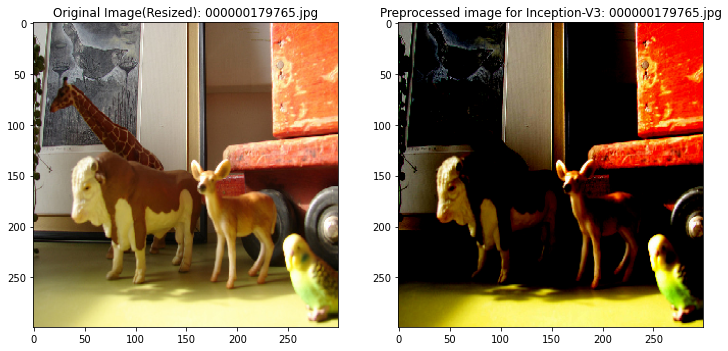

In [ ]:
## test out the preprocessing function on one image
##     while calling fuction set debug flag to true to display the original and preprocessed images
i = 0
for key in descriptions.keys():   ## key is the image name itself without the .jpg
  if i > 0:
    break
  
  imgpath = ''.join([IPDIRIMGS, '000000289393', '.jpg'])
  #imgpath = ''.join([IPDIRIMGS, key, '.jpg'])
  print(f"Image path = {imgpath}")
  preproc_img = preprocess_image_for_Incepv3(imgpath, _key=key, _DEBUG=True)
  print(f"Shape after preprocessing = {preproc_img.shape}")
  i += 1

### Load pre-trained model of Inception-v3 pretrained on Imagenet
### Then, Encode images into feature vectors and save it to disk
###
### Doing this in advance so that the feature vector representation of images is already available. Will drastically speed up training

In [ ]:
#Load pre-trained model and remove the last layer (Output layer)

# Load Inception-V3 model
model_inception_v3_pretrained_imagement = tf.keras.applications.InceptionV3(weights='imagenet')

# Create new model, by removing last layer (output layer) from Inception-V3
model_CNN_encoder = keras.Model(inputs=model_inception_v3_pretrained_imagement.input, outputs=model_inception_v3_pretrained_imagement.layers[-2].output)

#model_CNN_encoder.summary()

96116736/96112376 [==============================] - 4s 0us/step


In [ ]:
## Take each image and run it through the encoder. The feature of each image is a numpy array of 2048 values.
## 
## Store all the info image-wise into a dict with image name as key, the 2048 features as the value.
##       E.g. of an entry
##            print(len(img_encodings['000000179765'])) = 
##                                                         {'000000179765': array([0.14290829, 0.14481416, 0.3019989 , ..., 0.20583093, 0.13783988,
##                                                         0.05842407], dtype=float32), '000000190236': array([0.13693394, 0.44518015, 0.8012958 , ..., 0.09661996, 0.5428589 ,
##                                                         0.12551732], dtype=float32)}
## 
## Bottleneck processing. For 5k images took around 40 minutes.
##       So pickle for later use

In [ ]:
# Function to encode given image into a vector of size (2048, )
def encode_image(_imgpath, _key = 'DUMMY', _DEBUG=False):
    preproc_img = preprocess_image_for_Incepv3(_imgpath, _key = 'DUMMY', _DEBUG=False) # preprocess image per Inception-v3 requirements
    encoded_features = model_CNN_encoder.predict(preproc_img) # Get encoding vector for image
    encoded_features = encoded_features.reshape(encoded_features.shape[1], ) # reshape from (1, 2048) to (2048, )
    return encoded_features

In [ ]:
## actually encode the images and capture entries in dictionary with key as the filename only without the full path or the .jpg extension
##     using same key as the hashmap for captions uses

## sending all the val2017 images
start_time = time.time()
img_encodings = {}
for idx, img_filename_only in enumerate(descriptions.keys()):
  if False:  ## debugging
    if idx > 1:
      break
  img_encodings[img_filename_only] = encode_image(''.join([IPDIRIMGS, img_filename_only, '.jpg']))
  if( (idx+1)%200 == 0):
    print(f'Count of images encoded = {idx+1}')

print(f"Encoded {idx} images; total time taken = {time.time()-start_time} seconds")

Count of images encoded = 200
Count of images encoded = 400
Count of images encoded = 600
Count of images encoded = 800
Count of images encoded = 1000
Count of images encoded = 1200
Count of images encoded = 1400
Count of images encoded = 1600
Count of images encoded = 1800
Count of images encoded = 2000
Count of images encoded = 2200
Count of images encoded = 2400
Count of images encoded = 2600
Count of images encoded = 2800
Count of images encoded = 3000
Count of images encoded = 3200
Count of images encoded = 3400
Count of images encoded = 3600
Count of images encoded = 3800
Count of images encoded = 4000
Count of images encoded = 4200
Count of images encoded = 4400
Count of images encoded = 4600
Count of images encoded = 4800
Count of images encoded = 5000
Encoded 4999 images; total time taken = 3543.5187644958496 seconds


In [ ]:
len(img_encodings)  ## should be number of images i.e. 5000

5000

In [ ]:
OPDIR

'/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/'

In [ ]:
## pickle the data
with open(OPDIR+'val2017_all_5k_images_encoded_features_pickled_2.pkl', 'wb') as handle:
  pickle.dump(img_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done")

print(f"Size of pickled data = {sys.getsizeof(img_encodings)} bytes")

Pickling done
Size of pickled data = 147560 bytes


In [ ]:
img_encodings['000000179765']

array([0.14290808, 0.14481388, 0.30199888, ..., 0.20583029, 0.1378399 ,
       0.05842396], dtype=float32)

In [ ]:
del img_encodings

## ALWAYS - Data Preprocessing — Images - RELOAD FROM PICKLE FILE: Image encodings info obtained from encoder
### img_encodings['000000179765'] should be as below:

#### array([0.14290808, 0.14481388, 0.30199888, ..., 0.20583029, 0.1378399 ,
####        0.05842396], dtype=float32)

In [21]:
## reload from picked file
if True:
  with open(OPDIR+'val2017_all_5k_images_encoded_features_pickled_2.pkl', 'rb') as handle:
    img_encodings = pickle.load(handle)

#img_encodings

In [22]:
## should be = 147560 bytes
print(f"Size of reloaded pickled data = {sys.getsizeof(img_encodings)} bytes")

Size of reloaded pickled data = 147560 bytes


In [23]:
img_encodings['000000179765']

array([0.14290808, 0.14481388, 0.30199888, ..., 0.20583029, 0.1378399 ,
       0.05842396], dtype=float32)

## ALWAYS - Data Preprocessing — Captions
### 1) Build the word and index mapping dictionaries based on the reduced vocabulary.
### 2) Find the maximum length of captions
###    NOTE: This is using the original descriptions without the startseq and endseq word insertions

In [24]:
### We want to predict the captions. So while training, the captions are the target variables (Y)
### But the prediction of caption happens word by word, not in one go.
### So encode each word into a fixed sized vector later (GloVe).
### Here create the word-to-index and index-to-word dictionaries.
###
### We represent every unique word in the vocabulary by an integer (index).
### From the culled vocab (high freq words including the zero), we have 1523 unique words
###      in our corpus and thus each word will be represented by an integer index between 1 to 1523.
###
### Create two dictionaries:
###        wordtoix[‘abc’] -> returns index of the word ‘abc’
###        ixtoword[k] -> returns the word whose index is ‘k’

In [25]:
## NOTE: using the vocab_threhold
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab_threshold:
  wordtoix[w] = ix
  ixtoword[ix] = w
  ix += 1

In [26]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
 all_desc = list()
 for key in descriptions.keys():
  [all_desc.append(d) for d in descriptions[key]]
 return all_desc
# calculate the length of the description with the most words
def max_length(descriptions):
 lines = to_lines(descriptions)
 return max(len(d.split()) for d in lines)
# determine the maximum sequence length
max_length = max_length(descriptions)
print(f"Max Description Length: {max_length}")

Max Description Length: 45


## Data Preparation using Generator Function

In [ ]:
Hereafter, I will try to explain the remaining steps by taking a sample example as follows:
Consider we have 3 images and their 3 corresponding captions as follows:

(Train image 1) Caption -> The black cat sat on grass
(Train image 2) Caption -> The white cat is walking on road
(Test image) Caption -> The black cat is walking on grass

Now, let’s say we use the first two images and their captions to train the model and the third image to test our model.
Now the questions that will be answered are: how do we frame this as a supervised learning problem?, what does the data matrix look like? how many data points do we have?, etc.
First we need to convert both the images to their corresponding 2048 length feature vector as discussed above. Let “Image_1” and “Image_2” be the feature vectors of the first two images respectively
Secondly, let’s build the vocabulary for the first two (train) captions by adding the two tokens “startseq” and “endseq” in both of them: (Assume we have already performed the basic cleaning steps)

Caption_1 -> “startseq the black cat sat on grass endseq”
Caption_2 -> “startseq the white cat is walking on road endseq”

vocab = {black, cat, endseq, grass, is, on, road, sat, startseq, the, walking, white}

Let’s give an index to each word in the vocabulary:
black -1, cat -2, endseq -3, grass -4, is -5, on -6, road -7, sat -8, startseq -9, the -10, walking -11, white -12

Now let’s try to frame it as a supervised learning problem where we have a set of data points D = {Xi, Yi}, where Xi is the feature vector of data point ‘i’ and Yi is the corresponding target variable.

Let’s take the first image vector Image_1 and its corresponding caption “startseq the black cat sat on grass endseq”. Recall that, Image vector is the input and the caption is what we need to predict. But the way we predict the caption is as follows:
For the first time, we provide the image vector and the first word as input and try to predict the second word, i.e.:
Input = Image_1 + ‘startseq’; Output = ‘the’
Then we provide image vector and the first two words as input and try to predict the third word, i.e.:
Input = Image_1 + ‘startseq the’; Output = ‘cat’
And so on . . .

Thus, we can summarize the data matrix for one image and its corresponding caption as follows:
Step 1 :: image feature = FeatVecImg1 :: Partial Caption = "startseq" :: Target Word = "the"
Step 2 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the" :: Target Word = "black"
Step 3 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the black" :: Target Word = "cat"
Step 4 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the black cat" :: Target Word = "sat"
Step 5 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the black cat sat" :: Target Word = "on"
Step 6 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the black cat sat on" :: Target Word = "grass"
Step 7 :: image feature = FeatVecImg1 :: Partial Caption = "startseq the black cat sat on grass" :: Target Word = "endseq"

It must be noted that, one image+caption is not a single data point but are multiple data points depending on the length of the caption.
All the above 7 data points together constitute the full data for one image and its caption!!!!
Similarly for second images, there will be multiple steps together that consitute its full data point.

We must now understand that in every data point, it’s not just the image which goes as input to the system, but also, a partial caption which helps to predict the next word in the sequence.
Since we are processing sequences, we will employ a Recurrent Neural Network to read these partial captions (more on this later).
However, we have already discussed that we are not going to pass the actual English text of the caption, rather we are going to pass the sequence of indices where each index represents a unique word.

Since we have already created an index for each word, let’s now replace the words with their indices and understand how the data matrix will look like:
Step 1  :: image feature = FeatVecImg1 :: Partial Caption = "9" :: Target Word = "10"
Step 2  :: image feature = FeatVecImg1 :: Partial Caption = "9 10" :: Target Word = "1"
Step 3  :: image feature = FeatVecImg1 :: Partial Caption = "9 10 1" :: Target Word = "2"
Step 4  :: image feature = FeatVecImg1 :: Partial Caption = "9 10 1 2" :: Target Word = "8"
Step 5  :: image feature = FeatVecImg1 :: Partial Caption = "9 10 1 2 8" :: Target Word = "6"
Step 6  :: image feature = FeatVecImg1 :: Partial Caption = "9 10 1 2 8 6" :: Target Word = "4"
Step 7  :: image feature = FeatVecImg1 :: Partial Caption = "9 10 1 2 8 6 4" :: Target Word = "3"
Step 8  :: image feature = FeatVecImg2 :: Partial Caption = "9" :: Target Word = "10"
Step 9  :: image feature = FeatVecImg2 :: Partial Caption = "9 10" :: Target Word = "12"
Step 10 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12" :: Target Word = "2"
Step 11 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12 2" :: Target Word = "5"
Step 12 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12 2 5" :: Target Word = "11"
Step 13 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12 2 5 11" :: Target Word = "6"
Step 14 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12 2 5 11 6" :: Target Word = "7"
Step 15 :: image feature = FeatVecImg2 :: Partial Caption = "9 10 12 2 5 11 6 3" :: Target Word = "3"

Since we would be doing batch processing (explained later), we need to make sure that each sequence is of equal length. Hence we need to append 0’s (zero padding) at the end of each sequence. But how many zeros should we append in each sequence?
Well, this is the reason we had calculated the maximum length of a caption. So we will append those many number of zeros which will lead to every sequence having a length = maximum length of caption.

Step 1  :: image feature = FeatVecImg1 :: Partial Caption = "[9 0 0 ...]" :: Target Word = "10"
Step 2  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 0 0 ...]" :: Target Word = "1"
Step 3  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 1 0 0 ...]" :: Target Word = "2"
Step 4  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 1 2 0 0 ...]" :: Target Word = "8"
Step 5  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 1 2 8 0 0 ...]" :: Target Word = "6"
Step 6  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 1 2 8 6 0 0 ...]" :: Target Word = "4"
Step 7  :: image feature = FeatVecImg1 :: Partial Caption = "[9 10 1 2 8 6 4 0 0 ...]" :: Target Word = "3"
Step 8  :: image feature = FeatVecImg2 :: Partial Caption = "[9 0 0 ...]" :: Target Word = "10"
Step 9  :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 0 0 ...]" :: Target Word = "12"
Step 10 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 0 0 ...]" :: Target Word = "2"
Step 11 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 2 0 0 ...]" :: Target Word = "5"
Step 12 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 2 5 0 0 ...]" :: Target Word = "11"
Step 13 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 2 5 11 0 0 ...]" :: Target Word = "6"
Step 14 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 2 5 11 6 0 0 ...]" :: Target Word = "7"
Step 15 :: image feature = FeatVecImg2 :: Partial Caption = "[9 10 12 2 5 11 6 3 0 0 ...]" :: Target Word = "3"
Appended adequete 0's to each partial caption to make its length = max length



Need for a Data Generator:
In the above example, I have only considered 2 images and captions which have lead to 15 data points.
However, in our actual training dataset we have 6000 images, each having 5 captions. This makes a total of 30000 images and captions.
Even if we assume that each caption on an average is just 7 words long, it will lead to a total of 30000*7 i.e. 210000 data points.

Compute the size of the data matrix:


   img_vector = 2048        partial caption (length = max caption length)
---------------------------------------------------------------------------
-                       -                                                 -
-                       -                                                 -
-                       -                                                 -
-                       -                                                 -
---------------------------------------------------------------------------
Say above matrix has n rows, m columns, so Size of the data matrix = n*m
n-> number of data points (assumed as 210000)  (6000 images * 5 captions per image * 7 words average legnth of each caption)
m-> length of each data point
    = 2048 + length of partial caption (say something)
    = 2048 + something

Now this "something"  NOTE EQUAL to the max length of caption!
Every word (or index) will be mapped (embedded) to higher dimensional space through one of the word embedding techniques.
As we using GloVe-200, each embedding has 200 floats representing each number.

So with each caption sentence consisting of max length caption size word-indexes, each word represented by 200 dimensional value:
   Assuming max lenght of caption = 45
   means "something" = 2048 + ( 45 * 200 ) = 2048 + 9000 = 11048 float values to represent each sentence

Therefore, size of data matrix = m*n = 210000 * 11048 = xxx float values!!!
Assuming float takes 2 bytes (very conservative), that still means xxx * 2 = xxx GB

This is pretty huge requirement and even if we are able to manage to load this much data into the RAM, it will make the system very slow.
For this reason we use data generators a lot in Deep Learning. Data Generators are a functionality which is natively implemented in Python. The ImageDataGenerator class provided by the Keras API is nothing but an implementation of generator function in Python.

So how does using a generator function solve this problem?
If you know the basics of Deep Learning, then you must know that to train a model on a particular dataset, we use some version of Stochastic Gradient Descent (SGD) like Adam, Rmsprop, Adagrad, etc.
With SGD, we do not calculate the loss on the entire data set to update the gradients. Rather in every iteration, we calculate the loss on a batch of data points (typically 64, 128, 256, etc.) to update the gradients.

This means that we do not require to store the entire dataset in the memory at once. Even if we have the current batch of points in the memory, it is sufficient for our purpose.
A generator function in Python is used exactly for this purpose. It’s like an iterator which resumes the functionality from the point it left the last time it was called.
To understand more about Generators, please read here (https://wiki.python.org/moin/Generators).


In [27]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

## ONLY ONCE - GloVe vectors (Global Vectors for Word Representation)
### Citing GloVe: Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]GloVe: Global Vectors for Word Representation. [pdf] [bib]
### Link: More details on this here- https://nlp.stanford.edu/projects/glove/

In [28]:
## Download pre-trained word vectors
###    This data is made available under the Public Domain Dedication and License v1.0 whose full text can be found at: http://www.opendatacommons.org/licenses/pddl/1.0/.
###    Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip
###    Common Crawl (42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download): glove.42B.300d.zip
###    Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download): glove.840B.300d.zip
###    Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip

### Am using glove.6B.zip on 14.09.2020
### Then its glove.6B.200d.txt file for the 200 dimensional word embeddings

In [29]:
#Load GloVe vectors (Global Vectors for Word Representation) - 200 dimensional representation being used
## create the various data structures for use later

## loading glove and creating embeddings dict based on this link: https://github.com/epicalyx/Emojifier/blob/master/emo_utils.py

def load_glove_file_make_embeddings_dict():
  with open(WORD_EMBEDDINGS_DIR+'glove.6B.200d.txt', encoding="utf-8") as fglove:
    embeddings_dict_glove200 = {} # empty dictionary
    words_glove = set()
    for line in fglove:
      line = line.strip().split()
      curr_word = line[0]
      words_glove.add(curr_word)
      embeddings_dict_glove200[curr_word] = np.array(line[1:], dtype=np.float64)
    
    return embeddings_dict_glove200

embeddings_dict_glove200 = load_glove_file_make_embeddings_dict()
print(f"Number of words in this embeddings file = {len(embeddings_dict_glove200)}")
print(f"Shape of random word = {embeddings_dict_glove200['1917'].shape}")
print(f"Shape of another random word = {embeddings_dict_glove200['sculpture'].shape}")
print(f"Size of embeddings_dict_glove200 = {sys.getsizeof(embeddings_dict_glove200)/1000000} MB")

Number of words in this embeddings file = 400000
Shape of random word = (200,)
Shape of another random word = (200,)
Size of embeddings_dict_glove200 = 20.971616 MB


In [30]:
OPDIR

'/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/'

In [31]:
## pickle the emdbedding dict

with open(OPDIR+'glove200_embeddings_dict_1.pkl', 'wb') as handle:
    pickle.dump(embeddings_dict_glove200, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done for the embeddings_dict_glove200")

Pickling done for the embeddings_dict_glove200


In [32]:
del embeddings_dict_glove200 

In [33]:
embeddings_dict_glove200

NameError: ignored

## ALWAYS - RELOAD FROM PICKLE FILE:  Reload the GloVe vectors related data structures

### Sizes of reloaded pickled data should be =
#### Size of embeddings_dict_glove200 = 20.971616 MB

### Citing GloVe: Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]GloVe: Global Vectors for Word Representation. [pdf] [bib]
### Link: More details on this here- https://nlp.stanford.edu/projects/glove/

In [34]:
## Already downloaded the glove file and used it to create the embeddings dict and pickled it. Reloading now.
###    This data is made available under the Public Domain Dedication and License v1.0 whose full text can be found at: http://www.opendatacommons.org/licenses/pddl/1.0/.
###    Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip
###    Common Crawl (42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download): glove.42B.300d.zip
###    Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download): glove.840B.300d.zip
###    Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip

### Am using glove.6B.zip on 14.09.2020
### Then its glove.6B.200d.txt file for the 200 dimensional word embeddings

In [35]:
OPDIR

'/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoVal2017_1/'

In [36]:
## reload from picked files

if True:
  with open(OPDIR+'glove200_embeddings_dict_1.pkl', 'rb') as handle:
    embeddings_dict_glove200 = pickle.load(handle)

print(f"Number of words in this embeddings file = {len(embeddings_dict_glove200)}")
print(f"Shape of random word = {embeddings_dict_glove200['1917'].shape}")
print(f"Shape of another random word = {embeddings_dict_glove200['sculpture'].shape}")
print(f"Size of embeddings_dict_glove200 = {sys.getsizeof(embeddings_dict_glove200)/1000000} MB")

Number of words in this embeddings file = 400000
Shape of random word = (200,)
Shape of another random word = (200,)
Size of embeddings_dict_glove200 = 20.971616 MB


## NEXT SECTION - PENDING